In [2]:
import matplotlib.pyplot as plt
import gtsa
from pathlib import Path
import psutil
import pandas as pd
import torch
import gpytorch
import numpy as np


## Batch GP with GPytorch

In [3]:




def gpytorch_1d_batch_model(train_x, train_y, base_kernel, batch_size, noise = 1e-1):

    # Batch 1D kernel
    class Batch1D(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(Batch1D, self).__init__(train_x, train_y, likelihood)
            num_dims = train_x.size(-1)
            self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([batch_size]))
            base_kernel.batch_shape = torch.Size([batch_size])
            self.covar_module = base_kernel
        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_shape=torch.Size([batch_size]))
    model = Batch1D(train_x, train_y, likelihood)

    # Initialize parameters for product kernel
    model.likelihood.noise_covar.noise = torch.tensor(noise).float()
    model.mean_module.constant = torch.mean(train_y).float()

    return model



def gpytorch_predict_1d_batch(kernel, gridx, x_in, data_batch, iterations = False, use_gpu=False, love=False, rank=100):

    # Convert variogram form and parameters into base kernel form and parameters
    #base_kernel_name, lengthscale, outputscale = conversions.convert_kernel_pykrige_to_gp(variogram_model)

    batch_size = data_batch.shape[0]

    # Convert x/y grid into
    grid_coords = torch.from_numpy(np.repeat(gridx.reshape((1, -1)), batch_size, axis=0)).reshape((batch_size, -1, 1))

    # X data is single coordinates (1 column)
    train_x = torch.from_numpy(x_in.reshape((batch_size, -1, 1)))
    # Y data are values to predict (1 column)
    train_y = torch.from_numpy(data_batch)

    #base_kernel = getattr(gpytorch.kernels, base_kernel_name + "Kernel")  # GPyTorch adds "Kernel" to each name

    # Define model and fix covariance parameters
    model = gpytorch_1d_batch_model(train_x=train_x, train_y=train_y, base_kernel=kernel,batch_size=batch_size)
    likelihood = model.likelihood

    if use_gpu:
        train_x = train_x.cuda()
        train_y = train_y.cuda()
        model = model.cuda()
        likelihood = likelihood.cuda()
        grid_coords = grid_coords.cuda()



    # this is for running the notebook in our testing framework
    import os
    training_iter = 100


    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    if iterations:
        # Use the adam optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for i in range(training_iter):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, train_y).sum()
            loss.backward()
            print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
            optimizer.step()



    # Predict
    model.eval()  # We go in eval mode without training
    likelihood.eval()
    if love:
        with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(rank):
            observed_pred = likelihood(model(grid_coords))  # And predict on the grid coordinates
    else:
        with torch.no_grad():
            observed_pred = likelihood(model(grid_coords))


    means = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

    if use_gpu:
        means = means.cpu()
        upper = upper.cpu()
        lower = lower.cpu()

    sigmas = (upper - means) / 2  # Returns two STD

    return means.numpy(), sigmas.numpy(), model


# Define a function that handles each chunk
def process_chunk(dataarray, times, prediction_time_series, err, kernel, iterations):



    data_original = dataarray
    sizes = data_original.shape
    data_batch = data_original.reshape(data_original.shape[0], -1)


    ind_valid = np.isfinite(data_batch)
    data_cheat = data_batch.copy()
    err_cheat = err.copy()
    time_cheat = times.copy()

    # Expand coordinates to match size of data
    time_cheat_expanded = np.tile(time_cheat[:, np.newaxis], (1, data_cheat.shape[1]))
    # Expand errors to match size of data
    err_cheat_expanded = np.tile(err_cheat[:, np.newaxis], (1, data_cheat.shape[1]))

    # Get the first valid index for each column
    ind_first = np.argmax(ind_valid, axis=0)

    # Select the first valid values for each column using advanced indexing
    first_valid_values = data_cheat[ind_first, np.arange(data_cheat.shape[1])]
    first_valid_time = time_cheat_expanded[ind_first, np.arange(time_cheat_expanded.shape[1])]

    # Broadcast first valid values to fill NaNs in data_cheat
    data_cheat[~ind_valid] = np.take(first_valid_values, np.where(~ind_valid)[1])
    time_cheat_expanded[~ind_valid] = np.take(first_valid_time, np.where(~ind_valid)[1])

    # Get amount of invalid data per point
    nb_invalid = np.count_nonzero(~ind_valid, axis=0)


    # Calculate the error for the invalid points
    err_first = np.sqrt(err[ind_first]**2 * (nb_invalid + 1))  # Invalid points + 1 for the original point

    # Expand err_first to match the size of err_cheat and assign to the invalid positions
    err_cheat_expanded[~ind_valid] = np.take(err_first, np.where(~ind_valid)[1])
    err_cheat_expanded[:, ind_first] = err_first

    # Transpose them all
    data_cheat = data_cheat.T
    time_cheat_expanded = time_cheat_expanded.T
    err_cheat_expanded = err_cheat_expanded.T


    yb, sb, mb = gpytorch_predict_1d_batch(kernel, prediction_time_series, time_cheat_expanded, data_cheat, iterations,
                                                                    use_gpu=False, love=True,
                                                                    rank=False)
    yb = yb.T.reshape(-1, sizes[1], sizes[2])
    sb = sb.T.reshape(-1, sizes[1], sizes[2])

    return yb, sb

## Create GPytorch kernel based on GTSA's

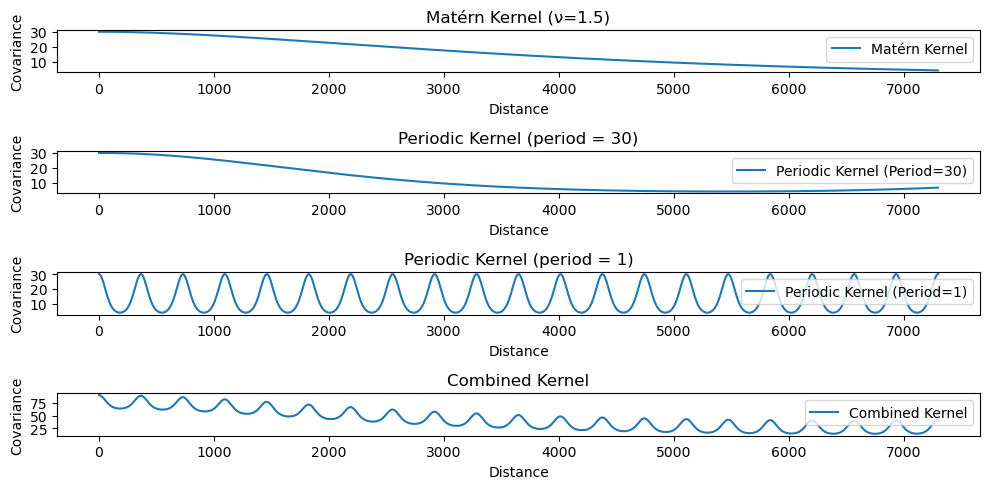

In [4]:
# Define the range of distances to evaluate the kernel
x = torch.linspace(0, 20*365, 500).unsqueeze(1)  # Column vector

# Define Matérn kernel
matern_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))
matern_kernel.outputscale = 30.0  # Scaling factor
matern_kernel.base_kernel.lengthscale = 365*10.0  # Lengthscale

# Define the second kernel (Periodic with constant scale)
k2 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
k2.outputscale = 30.0  # Equivalent to ConstantKernel(30)
k2.base_kernel.lengthscale = 1.0
k2.base_kernel.period_length = 365*30.0  # Equivalent to periodicity=30

# Define the third kernel (Another periodic kernel with different periodicity)
k3 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
k3.outputscale = 30.0
k3.base_kernel.lengthscale = 1.0
k3.base_kernel.period_length = 365*1.0  # Equivalent to periodicity=1

# Combine the kernels
kernel = matern_kernel + k2 + k3

# Compute covariance matrices
K_matern = matern_kernel(x, torch.zeros(1)).evaluate().detach().numpy()
K_periodic1 = k2(x, torch.zeros(1)).evaluate().detach().numpy()
K_periodic2 = k3(x, torch.zeros(1)).evaluate().detach().numpy()
K_total = kernel(x, torch.zeros(1)).evaluate().detach().numpy()

# Plot kernels
plt.figure(figsize=(10, 5))

plt.subplot(4, 1, 1)
plt.plot(x.numpy(), K_matern, label="Matérn Kernel")
plt.xlabel("Distance")
plt.ylabel("Covariance")
plt.title("Matérn Kernel (ν=1.5)")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(x.numpy(), K_periodic1, label="Periodic Kernel (Period=30)")
plt.xlabel("Distance")
plt.ylabel("Covariance")
plt.title("Periodic Kernel (period = 30)")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(x.numpy(), K_periodic2, label="Periodic Kernel (Period=1)")
plt.xlabel("Distance")
plt.ylabel("Covariance")
plt.title("Periodic Kernel (period = 1)")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(x.numpy(), K_total, label="Combined Kernel")
plt.xlabel("Distance")
plt.ylabel("Covariance")
plt.title("Combined Kernel")
plt.legend()

plt.tight_layout()
plt.show()

## Import the example DEMs

In [ ]:
workers = psutil.cpu_count(logical=True)-1
client = gtsa.io.dask_start_cluster(workers,
                                    ip_address=None, # replace with address if working on remote machine
                                    port='8787', # if occupies a different port will automatically be assigned
                                   )

# Define the data directory
data_dir = '../../data/dems/south-cascade'

# List all DEMs in the directory
dems = [x.as_posix() for x in sorted(Path(data_dir).glob('*.tif'))]
date_strings = [x[1:-1] for x in gtsa.io.parse_timestamps(dems,date_string_pattern='_........_')]
date_strings, dems = list(zip(*sorted(zip(date_strings, dems)))) # ensure chronological sorting 
date_times = [pd.to_datetime(x, format="%Y%m%d") for x in date_strings]
ref_dem = dems[-1] # always last after chronological sorting

# Create a stack of geotiffs
ds = gtsa.io.xr_stack_geotifs(dems,
                              date_times,
                              ref_dem,
                              resampling="bilinear",
                              save_to_nc = True,
                              nc_out_dir = Path(data_dir,'spatial').as_posix(),
                              overwrite = False)


Dask dashboard at: http://127.0.0.1:8787/status
Workers: 15
Threads per worker: 1 



## Estimate error from the reference DEM

- The first cell should work if you provide a reference DEM as well as a glacier mask (both as xdem.DEM() objects)
- If not, randomly select values between 5 and 20

In [ ]:
#def error_wrapper(da, reference_raster, glacier_mask_reprojected):


#    if np.all(~np.isfinite(da)):
#        return np.nan
#    else:
#        dem = xdem.DEM.from_array(da, transform=reference_raster.transform, crs=reference_raster.crs)
#        uncertainty, variogram = dem.estimate_uncertainty(reference_raster, stable_terrain=glacier_mask_reprojected)
#        return uncertainty.data.data



#ds = ds.chunk({"time": -1, "x": 100, "y": 100})
#error = np.zeros(ds["band1"].shape[0])

#for i in tqdm(range(ds["band1"].shape[0])):
#    try:
#        test = error_wrapper(ds["band1"].isel(time=i).values, xdem.DEM(reference_raster), glacier_mask_reprojected)
#        error[i] = np.nanmean(test)
#    except:
#        error[i] = np.nan
#        print(f"Failed for {i}")

#error[np.isnan(error)] = np.nanmean(error)

In [ ]:
# Sample of errors
err = np.random.uniform(5, 20, size=len(date_times))

## Generate the prediction time series
Done differently than in GTSA's example

In [ ]:
# Extract start and end dates
start_date = pd.Timestamp(ds['band1'].time.values[0])
end_date = pd.Timestamp(ds['band1'].time.values[-1])

# Generate a date range with the 15th of each month
date_range = pd.date_range(start=start_date, end=end_date, freq='MS') + pd.DateOffset(days=14)

# Convert to float days since the first time value
times_15th = (date_range.to_numpy() - np.datetime64(start_date)) / np.timedelta64(1, 'D')

# Convert to a float numpy array
prediction_time_series = times_15th.astype(float)

## Run the GPytorch algorithm in parallel without Dask

#### This first example works but is SLOW

In [ ]:
from joblib import Parallel, delayed
import numpy as np
import dask.array as da

dataarray = ds["band1"]
times = (((ds['band1'].time.values)-ds['band1'].time.values[0])/np.timedelta64(1, 'D'))

def process_wrapper(y_start, x_start, chunk_size_y, chunk_size_x):
    chunk = dataarray[:, y_start:y_start + chunk_size_y, x_start:x_start + chunk_size_x]
    yb, sb = process_chunk(chunk, times, prediction_time_series, err, kernel, iterations=False)
    return (y_start, x_start, yb, sb)

# Chunk size
chunk_size_y, chunk_size_x = 50, 50

# Define grid indices
y_starts = range(0, dataarray.shape[1], chunk_size_y)
x_starts = range(0, dataarray.shape[2], chunk_size_x)

# Run in parallel
from tqdm import tqdm

results = Parallel(n_jobs=4)(
    delayed(process_wrapper)(y, x, chunk_size_y, chunk_size_x) 
    for y, x in tqdm([(y, x) for y in y_starts for x in x_starts], desc="Processing chunks")
)

# Reconstruct full arrays
yb_full = np.empty_like(dataarray)
sb_full = np.empty_like(dataarray)

for y_start, x_start, yb, sb in results:
    yb_full[:, y_start:y_start + chunk_size_y, x_start:x_start + chunk_size_x] = yb
    sb_full[:, y_start:y_start + chunk_size_y, x_start:x_start + chunk_size_x] = sb

#### Attempt at Dask GP with GPytorch


In [ ]:
def parallelize_processing(dataset, times, prediction_time_series, err, kernel, iterations):
    results = xr.apply_ufunc(
        process_chunk, 
        dataset, 
        input_core_dims=[['time', 1084, 1375]],
        output_core_dims=[['time', 'y', 'x'], ['time', 'y', 'x']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float, float],
        dask_gufunc_kwargs={'allow_rechunk': False},
        kwargs={
            'times': times,
            'prediction_time_series': prediction_time_series,
            'err': err,
            'kernel': kernel,
            'iterations': iterations
        }
    )
    
    return results


times = (((ds['band1'].time.values)-ds['band1'].time.values[0])/np.timedelta64(1, 'D'))
results_yb, results_sb = parallelize_processing(ds, times, prediction_time_series, err, kernel, False)

## GTSA Scikit interpolation with error as 1D input vector (1 error value per time slice)

#### Define scikit kernel

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, ExpSineSquared

# Define the kernels
k1 = 30.0 * Matern(length_scale=365*10.0, nu=1.5)
k2 = ConstantKernel(30) * ExpSineSquared(length_scale=1, periodicity=30*365)
k3 = ConstantKernel(30) * ExpSineSquared(length_scale=1, periodicity=365)

# Combined kernel
kernel = k1 + k2 + k3

# Generate sample points
x = np.linspace(0, 365*20, 500)[:, np.newaxis]
x = (((ds['DEM'].time.values)-ds['DEM'].time.values[0])/np.timedelta64(1, 'D'))[:, np.newaxis]

# Compute the kernel values
k1_values = k1(x, x[0:1])
k2_values = k2(x, x[0:1])
k3_values = k3(x, x[0:1])
kernel_values = kernel(x, x[0:1])

# Plot each kernel
plt.figure(figsize=(12, 8))

# Plot k1
plt.subplot(4, 1, 1)
plt.plot(x, k1_values, label="k1: Matern (length_scale=10, nu=1.5)", color='blue')
plt.legend()
plt.grid()

# Plot k2
plt.subplot(4, 1, 2)
plt.plot(x, k2_values, label="k2: Constant * ExpSineSquared (periodicity=30)", color='green')
plt.legend()
plt.grid()

# Plot k3
plt.subplot(4, 1, 3)
plt.plot(x, k3_values, label="k3: Constant * ExpSineSquared (periodicity=1)", color='red')
plt.legend()
plt.grid()

# Plot combined kernel
plt.subplot(4, 1, 4)
plt.plot(x, kernel_values, label="Combined Kernel: k1 + k2 + k3", color='purple')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
from dask.diagnostics import ProgressBar

with ProgressBar():
        ds_result_scikit = gtsa.temporal.dask_apply_GPR(ds['band1'],
                                                'time', 
                                                kwargs={'times':(((ds['band1'].time.values)-ds['band1'].time.values[0])/np.timedelta64(1, 'D')),
                                                        'kernel': kernel,
                                                        'prediction_time_series' : prediction_time_series,
                                                        'iterations': False,
                                                        'n_iter': 0,
                                                        'alpha': err}
                                                ).compute()